In [ ]:
import numpy as np
import pandas as pd
import itertools
import time
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from matplotlib.ticker import FormatStrFormatter
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
##Suppress Warning##
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Subroutines For Jackknife+-after-bootstrap

#### Generating train/test split , & bootstrap samples:

In [ ]:
def data_split(X_full, Y_full, train_size):
    '''
      Sample n=200 data from the original dataset to be used as training data
      X_full: Full X data matrix (for communities/meps/blog)
      Y_full: Full Y data matrix (for communities/meps/blog)
      Return: A list of data matrices of train/test(or validation) pairs
    '''
    n_tot = len(Y_full)
    idx = np.random.choice(n_tot, train_size, replace=False)
    not_idx = [i not in idx for i in range(n_tot)]
    X_train = X_full[idx, :]
    X_test = X_full[not_idx, :]
    Y_train = Y_full[idx, ]
    Y_test = Y_full[not_idx, ]
    return([X_train, X_test, Y_train, Y_test])

In [ ]:
def generate_bootstrap_samples(n, m, B):
    '''
      Return: B-by-m matrix, where row b gives the indices for b-th bootstrap sample
    '''
    samples_idx = np.zeros((B, m),dtype=int)
    for b in range(B):
        sample_idx = np.random.choice(n, m)
        samples_idx[b, :] = sample_idx
    return(samples_idx)

#### Fitting bootstrap estimators:

In [ ]:
def fit_bootstrap_models(X_train, Y_train, X_predict, fit_muh_fun, n, m, B):
    '''
      Train B bootstrap estimators and calculate predictions on X_predict
      Return: list of matrices [M,P]
        samples_idx = B-by-m matrix, row b = indices of b-th bootstrap sample
        predictions = B-by-n1 matrix, row b = predictions from b-th bootstrap sample
          (n1=len(X_predict))
    '''
    samples_idx = generate_bootstrap_samples(n, m, B)
    n1 = len(X_predict)
    # P holds the predictions from individual bootstrap estimators
    predictions = np.zeros((B, n1), dtype=float)
    for b in range(B):
        predictions[b] = fit_muh_fun(X_train[samples_idx[b], :],\
                                     Y_train[samples_idx[b], ], X_predict)
    return([samples_idx, predictions])

In [ ]:
# Define Baseline Regressor to be used later
def ridge2(X,Y,X1,ridge_mult=0.001):
    # named ridge2 to distinguish it from the ridge regressor in sklearn.
    lam = ridge_mult * np.linalg.svd(X,compute_uv=False).max()**2
    betahat = np.linalg.solve(\
            np.c_[np.ones(X.shape[0]),X].T.dot(np.c_[np.ones(X.shape[0]),X]) \
                              + lam * np.diag(np.r_[0,np.ones(X.shape[1])]),
            np.c_[np.ones(X.shape[0]),X].T.dot(Y))
    return betahat[0] + X1.dot(betahat[1:])
  
def neural_net(X,Y,X1):
    nnet = MLPRegressor(solver='lbfgs',activation='logistic').fit(X,Y)
    return nnet.predict(X1)

def random_forest_nB(X,Y,X1,ntree=20):
    # when bootstrap=False, it means each tree is trained on all rows of X and only
    #      subsamples its columns (which are features).
    rf = RandomForestRegressor(n_estimators=ntree,criterion='mae',bootstrap=False,n_jobs=-1).fit(X,Y)
    return rf.predict(X1)

### Compute prediction intervals for Jackknife+-after-bootstrap


Include mean, median, and trimmed mean aggregation

In [ ]:
def compute_PIs_jacknife_plus_after_bootstrap(X,Y,X1,alpha,fit_muh_fun,B,m,aggre):
    '''
    Using mean aggregation
    '''
    n=len(X)
    n1 = len(X1)
    [boot_samples_idx,boot_predictions] = \
        fit_bootstrap_models(X, Y, np.vstack((X,X1)), fit_muh_fun, n, m, B)
    in_boot_sample = np.zeros((B,n),dtype=bool)
    for b in range(len(in_boot_sample)):
        in_boot_sample[b,boot_samples_idx[b]] = True
    resids_LOO = np.zeros(n)
    muh_LOO_vals_testpoint = np.zeros((n,n1))
    for i in range(n):
        b_keep = np.argwhere(~(in_boot_sample[:,i])).reshape(-1)
        if(len(b_keep)>0):
          if aggre=='mean':
            resids_LOO[i] = np.abs(Y[i] - boot_predictions[b_keep,i].mean())
            muh_LOO_vals_testpoint[i] = boot_predictions[b_keep,n:].mean(0)
          elif aggre=='median':
            resids_LOO[i] = np.abs(Y[i] - np.median(boot_predictions[b_keep,i]))
            muh_LOO_vals_testpoint[i] = np.median(boot_predictions[b_keep,n:],axis=0)
          elif aggre=='tmean':
            resids_LOO[i] = np.abs(Y[i] - stats.trim_mean(boot_predictions[b_keep,i],0.25))
            muh_LOO_vals_testpoint[i] = stats.trim_mean(boot_predictions[b_keep,n:],0.25,axis=0)
        else: # if aggregating an empty set of models, predict zero everywhere
            resids_LOO[i] = np.abs(Y[i])
            muh_LOO_vals_testpoint[i] = np.zeros(n1)
    ind_q = (np.ceil((1-alpha)*(n+1))).astype(int)
    ###############################
    # construct prediction intervals
    ###############################
        
    return pd.DataFrame(\
            np.c_[np.sort(muh_LOO_vals_testpoint.T - resids_LOO,axis=1).T[-ind_q], \
                np.sort(muh_LOO_vals_testpoint.T + resids_LOO,axis=1).T[ind_q-1]],\
                    columns = ['lower','upper'])

### Compute prediction intervals for Naive O(n*B) Jackknife+ (ensembled)

Include mean, median, and trimmed mean aggregation

In [ ]:
def compute_PIs_jacknife_plus_naive(X,Y,X1,alpha,fit_muh_fun,B,m,aggre):
    '''
    Using mean aggregation
    '''
    n=len(X)
    n1 = len(X1)
    resids_LOO = np.zeros(n)
    muh_LOO_vals_testpoint = np.zeros((n,n1))
    for i in range(n):
      boot_predictions = fit_bootstrap_models(np.delete(X,i,0), Y, np.vstack((X,X1)), fit_muh_fun, n-1, m, B)[1]
      if aggre=='mean':
        resids_LOO[i] = np.abs(Y[i] - np.mean(boot_predictions[:,i]))
        muh_LOO_vals_testpoint[i] = np.mean(boot_predictions[:,n:],axis=0)
      elif aggre=='median':
        resids_LOO[i] = np.abs(Y[i] - np.median(boot_predictions[:,i]))
        muh_LOO_vals_testpoint[i] = np.median(boot_predictions[:,n:],axis=0)
      elif aggre=='tmean':
        resids_LOO[i] = np.abs(Y[i] - stats.trim_mean(boot_predictions[:,i],0.25))
        muh_LOO_vals_testpoint[i] = stats.trim_mean(boot_predictions[:,n:],0.25,axis=0)
    ind_q = (np.ceil((1-alpha)*(n+1))).astype(int)
    ###############################
    # construct prediction intervals
    ###############################

    return pd.DataFrame(\
            np.c_[np.sort(muh_LOO_vals_testpoint.T - resids_LOO,axis=1).T[-ind_q], \
                np.sort(muh_LOO_vals_testpoint.T + resids_LOO,axis=1).T[ind_q-1]],\
                    columns = ['lower','upper'])

### Compute prediction intervals for Jackknife+ (non-ensembled)

In [ ]:
def compute_PIs_jacknife_plus(X,Y,X1,alpha,fit_muh_fun):
    n = len(X)
    n1 = len(X1)
    muh_vals = fit_muh_fun(X,Y,np.r_[X,X1])
    resids_naive = np.abs(Y-muh_vals[:n])
    muh_vals_testpoint = muh_vals[n:]
    resids_LOO = np.zeros(n)
    muh_LOO_vals_testpoint = np.zeros((n,n1))
    for i in range(n):
        muh_vals_LOO = fit_muh_fun(np.delete(X,i,0),np.delete(Y,i),\
                                   np.r_[X[i].reshape((1,-1)),X1])
        resids_LOO[i] = np.abs(Y[i] - muh_vals_LOO[0])
        muh_LOO_vals_testpoint[i] = muh_vals_LOO[1:]
    ind_q = (np.ceil((1-alpha)*(n+1))).astype(int)
    ###############################
    # construct prediction intervals
    ###############################
        
    return pd.DataFrame(\
            np.c_[np.sort(muh_LOO_vals_testpoint.T - resids_LOO,axis=1).T[-ind_q], \
                np.sort(muh_LOO_vals_testpoint.T + resids_LOO,axis=1).T[ind_q-1]],\
                    columns = ['lower','upper'])

### Run real data experiment

#### load data

In [ ]:
# UCI Communities and Crime Data Set
# http://archive.ics.uci.edu/ml/datasets/communities+and+crime
communities_data = np.loadtxt('communities_data.csv',delimiter=',',dtype=str)
# remove categorical predictors
communities_data = np.delete(communities_data, np.arange(5), 1)
# remove predictors with missing values
communities_data = np.delete(communities_data,            np.argwhere(
    (communities_data == '?').sum(0) > 0).reshape(-1), 1)
communities_data = communities_data.astype(float)
X_communities = communities_data[:, :-1]
Y_communities = communities_data[:, -1]

In [ ]:
# UCI BlogFeedback data set
# https://archive.ics.uci.edu/ml/datasets/BlogFeedback
blog_data = np.loadtxt('blogData_train.csv',delimiter=',')
X_blog = blog_data[:, :-1]
Y_blog = np.log(1+blog_data[:, -1])

In [ ]:
# MEPS data set
# data downloaded (in .ssp format) from:
# https://meps.ahrq.gov/mepsweb/data_files/pufs/h192ssp.zip
# then run get_meps_data.ipynb script
# to perform feature selection & data cleaning, & store to .txt file
meps_data = np.loadtxt('meps_data.txt')
X_meps = meps_data[:, :-1]
Y_meps = meps_data[:, -1]

### run experiment & save results

##### Main Experiments
Compare J+aB, J+ Ensemble, and J+ Non-ensemble under the same parameter choices


In [ ]:
# Initialize Parameters
alpha= 0.1
tot_trial = 10 
train_size = 40 # training size n
m_vals = np.round(train_size*np.linspace(0.2,1,num=5)).astype(int)
B_ = 20 # number of bootstrap samples in J+aB is drawn as B ~ Binomial(int(B_/(1-1/(n+1))^m),(1-1/(n+1))^m)

In [ ]:
# Run Mean, Median, and Trimmed Mean
fit_funcs = [ridge2,neural_net,random_forest_nB]
Data_name = ['meps','communities','blog']
for agg in ['mean','median','tmean']:
  results = pd.DataFrame(columns = ['itrial','dataset','muh_fun','method','coverage','width','time'])
  for data_name in Data_name:
      X = eval('X_'+data_name)
      Y = eval('Y_'+data_name)
      for ifunc in range(len(fit_funcs)):
          fit_func = fit_funcs[ifunc]
          print(f'Under {agg}: running '+fit_func.__name__+' on '+data_name)
          for itrial in range(tot_trial):
              print(f'At trial # {itrial}')
              np.random.seed(98765+itrial)
              [X_train, X_test, Y_train, Y_test] = data_split(X, Y, train_size)
              # Run J+ Non-ensemble
              print('On J+ Non-ensemble')
              start_time=time.time()
              PIs = compute_PIs_jacknife_plus(X_train,Y_train,X_test,alpha,fit_func)
              coverage = ((PIs['lower'] <= Y_test)&(PIs['upper'] >= Y_test)).mean()
              width = (PIs['upper'] - PIs['lower']).mean()
              results.loc[len(results)]=\
                  [itrial,data_name,fit_func.__name__,'jack+',coverage,width,time.time()-start_time]
              # Run J+ Ensemble and J+aB across all m values at train size = 40
              for m in m_vals:
                  # Naive J+
                  print('On J+ Ensemble')
                  start_time=time.time()
                  PIs = compute_PIs_jacknife_plus_naive(\
                              X_train,Y_train,X_test,alpha,fit_func,B_,m,agg)
                  coverage = ((PIs['lower'] <= Y_test)&(PIs['upper'] >= Y_test)).mean()
                  width = (PIs['upper'] - PIs['lower']).mean()
                  results.loc[len(results)]=\
                      [itrial,data_name,fit_func.__name__,'jack+-naive (m='+str(m)+')',\
                              coverage,width,time.time()-start_time]
                   # J+aB
                  start_time=time.time()
                  print('On J+aB')
                  B = int(np.random.binomial(int(B_/((1-1./(1+train_size))**m*(1-1./train_size)**m)),(1-1./(1+train_size))**m,size=1))
                  PIs = compute_PIs_jacknife_plus_after_bootstrap(\
                              X_train,Y_train,X_test,alpha,fit_func,B,m,agg)
                  coverage = ((PIs['lower'] <= Y_test)&(PIs['upper'] >= Y_test)).mean()
                  width = (PIs['upper'] - PIs['lower']).mean()
                  results.loc[len(results)]=\
                      [itrial,data_name,fit_func.__name__,'jack+aB (m='+str(m)+')',\
                              coverage,width,time.time()-start_time]
                  results.to_csv(f'{data_name}-main-results-{agg}.csv',index=False)

##### Supplementary Experiments
Compare J+aB with Random $B$ and with Fixed $B'$, making sure $E(B)=B'$

In [ ]:
# Initialize Parameters
alpha= 0.1
tot_trial = 10
train_size = 200 # training size n
m_vals = np.round(train_size*np.linspace(0.1,1,num=10)).astype(int)
B_ = 50 # number of bootstrap samples in J+aB is drawn as B ~ Binomial(int(B_/(1-1/(n+1))^m),(1-1/(n+1))^m)

In [ ]:
# Run Mean, Random vs. Fixed J+aB
fit_funcs = [ridge2,neural_net,random_forest_nB]
Data_name = ['meps','communities','blog']
for agg in ['mean','median','tmean']:
  results = pd.DataFrame(columns = ['itrial','dataset','muh_fun','method','coverage','width','time'])
  for data_name in Data_name:
      X = eval('X_'+data_name)
      Y = eval('Y_'+data_name)
      for ifunc in range(len(fit_funcs)):
          fit_func = fit_funcs[ifunc]
          print(f'Under {agg}: running '+fit_func.__name__+' on '+data_name)
          for itrial in range(tot_trial):
              print(f'trial # {itrial}')
              np.random.seed(98765+itrial)
              [X_train, X_test, Y_train, Y_test] = data_split(X, Y, train_size)
              # Run jackknife+aB, random B & non-random B
              for m in m_vals:
                  # J+aB, random B
                  start_time=time.time()
                  B = int(np.random.binomial(int(B_/(1-1./(1+train_size))**m),(1-1./(1+train_size))**m,size=1))
                  PIs = compute_PIs_jacknife_plus_after_bootstrap(\
                              X_train,Y_train,X_test,alpha,fit_func,B,m,agg)
                  coverage = ((PIs['lower'] <= Y_test)&(PIs['upper'] >= Y_test)).mean()
                  width = (PIs['upper'] - PIs['lower']).mean()
                  results.loc[len(results)]=\
                      [itrial,data_name,fit_func.__name__,'random-jack+aB (m='+str(m)+')',\
                              coverage,width,time.time()-start_time]
                  # J+aB, fixed B
                  start_time=time.time()
                  PIs = compute_PIs_jacknife_plus_after_bootstrap(\
                              X_train,Y_train,X_test,alpha,fit_func,B_,m,agg)
                  coverage = ((PIs['lower'] <= Y_test)&(PIs['upper'] >= Y_test)).mean()
                  width = (PIs['upper'] - PIs['lower']).mean()
                  results.loc[len(results)]=\
                      [itrial,data_name,fit_func.__name__,'fixed-jack+aB (m='+str(m)+')',\
                              coverage,width,time.time()-start_time]
                  results.to_csv(f'fixed-random-B-{agg}.csv',index=False)

### Plots & Table


#### Grouped Boxplots

In [ ]:
# For comparing  J+aB, J+ Ensemble, and J+ Non-ensemble under different aggregation method
def grouped_box_agg(agg, type):
    size = 6
    if type == 'coverage':
        f, ax = plt.subplots(3, 3, figsize=(size, size), sharex=True, sharey=True)
    else:
        f, ax = plt.subplots(3, 3, figsize=(size, size), sharex=True, sharey='row')
    f.tight_layout(pad=-0.3)
    i = 0  # row, denote dataset
    regrs = ['ridge2', 'random_forest_nB', 'neural_net']
    regrs_label = {'ridge2': 'RIDGE', 'random_forest_nB': "RF", 'neural_net': "NN"}
    # titles = {'mean': 'Mean', 'median': "Median", 'tmean': 'Trimmed Mean'}
    titles = {'meps': 'MEPS', 'blog': "BLOG", 'communities': "COMMUNITIES"}
    font_size = 12
    label_size = 14
    for dataname in ['meps', 'blog', 'communities']:
        j = 0  # column, denote regressor
        # for agg in ['mean', 'median', 'tmean']:
        for regr in regrs:
            results = pd.read_csv(f'{dataname}-main-results-{agg}.csv')
            results.loc[results.method == 'jack+', 'method'] = 'jack+ (m=0)'  # for plotting
            m_vals = np.array([int(mtd.split('=')[1].split(')')[0])
                               for mtd in results.method])  # get m value
            method_name = np.array([mtd.split(' ')[0] for mtd in results.method])
            results['method'] = method_name
            # For proper legend
            results['method'].replace('jack+-naive', 'J+ ENSEMBLE', inplace=True)
            results['method'].replace('jack+aB', 'J+aB', inplace=True)
            results['method'].replace('jack+', 'J+ NON-ENSEMBLE', inplace=True)
            results['ratio'] = m_vals/max(m_vals)
            mtd = ['J+ ENSEMBLE', 'J+aB', 'J+ NON-ENSEMBLE']
            mtd_colors = ['orange', 'royalblue', 'green']
            color_dict = dict(zip(mtd, mtd_colors))  # specify colors for each box
            # Start plotting
            sns.boxplot(y=type, x='ratio',
                                  data=results[results.muh_fun == regr],
                                  palette=color_dict,
                                  hue='method',
                                  hue_order=['J+ NON-ENSEMBLE', 'J+ ENSEMBLE', 'J+aB'],
                                  ax=ax[i, j])
            # Remove tick for J+ Non-ensemble
            xtick = ax[i, j].xaxis.get_major_ticks()
            xtick[0].set_visible(False)
            ax[i, j].tick_params(axis='both', which='major', labelsize=font_size)
            ax[i, j].get_legend().remove()
            if type == 'width':
                ax[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # no decimal
                # control y-range
                result_regr = results
                ax[i, j].set(ylim=(max(min(result_regr.width)-0.1, 0),
                                   max(result_regr.width)+0.1))
            if type == 'coverage':
                ax[i, j].axhline(y=0.9, color='black')
            if j == 0:
                # Y-label on
                ax[i, 0].set_ylabel(titles[dataname], fontsize=label_size)
                if i == 2:
                    # X-label on
                    ax[2, 0].set_xlabel('m/n', fontsize=label_size)
                    ax[2, j].tick_params(axis='x', rotation=45)
                else:
                    # X-label off
                    x_axis = ax[i, j].axes.get_xaxis()
                    x_axis.set_visible(False)
            else:
                # Y-label off but keep ticks
                ax[i, j].set_ylabel('')
                if i == 2:
                    # X-label on
                    ax[2, j].set_xlabel('m/n', fontsize=label_size)
                    ax[2, j].tick_params(axis='x', rotation=45)
                else:
                    # X-label off
                    x_axis = ax[i, j].axes.get_xaxis()
                    x_axis.set_visible(False)
            # Control Title
            if i == 0:
                ax[0, j].set_title(regrs_label[regr], fontsize=label_size)
                if j == 1 and type == 'coverage':
                    ax[0, j].set_title(f'Coverage \n {regrs_label[regr]}', fontsize=label_size)
                if j == 1 and type == 'width':
                    ax[0, j].set_title(f'Width \n {regrs_label[regr]}', fontsize=label_size)
            j += 1
        i += 1
    # Legend lastly
    # Assign to top middle
    ax[2, 1].legend(loc='upper center',
                    bbox_to_anchor=(0.4, -0.4), ncol=3, fontsize=font_size)
    # it would of course be better with a nicer handle to the middle-bottom axis object, but since I know it is the second last one in my 3 x 3 grid...
    plt.savefig(f'Boxplots_{agg}_{type}.pdf', dpi=300, bbox_inches='tight',
                pad_inches=0)


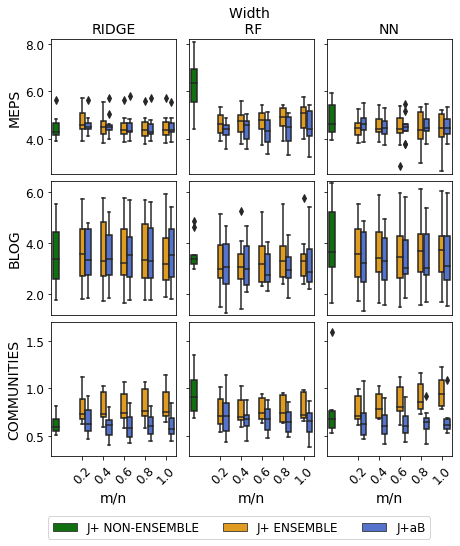

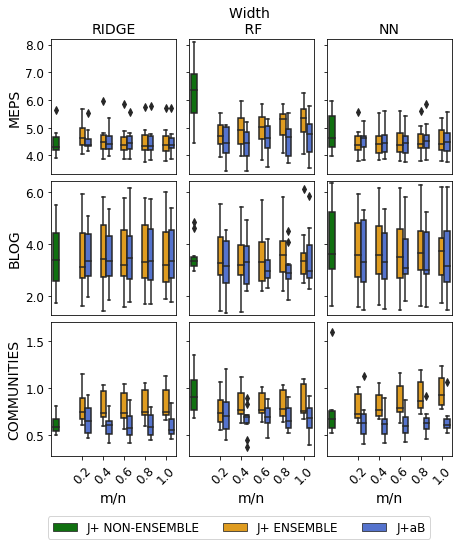

In [ ]:
for agg in ['mean', 'median', 'tmean']:
    grouped_box_agg(agg, 'coverage')
    grouped_box_agg(agg, 'width')

In [ ]:
# For comparing random vs. fixed B on J+aB
def grouped_box_rand_fix(agg, type):
    size = 6
    if type == 'coverage':
        f, ax = plt.subplots(3, 3, figsize=(size, size), sharex=True, sharey=True)
    else:
        # all plots in same row share y-axis
        f, ax = plt.subplots(3, 3, figsize=(size, size), sharex=True, sharey='row')
    f.tight_layout(pad=-0.3)
    i = 0  # row, denote regressor
    regrs = ['ridge2', 'random_forest_nB', 'neural_net']
    regrs_label = {'ridge2': 'RIDGE', 'random_forest_nB': "RF", 'neural_net': "NN"}
    # titles = {'mean': 'Mean', 'median': "Median", 'tmean': 'Trimmed Mean'}
    titles = {'meps': 'MEPS', 'blog': "BLOG", 'communities': "COMMUNITIES"}
    font_size = 12
    label_size=14
    for dataname in ['meps', 'blog', 'communities']:
        j = 0  # column, denote aggregator
        # for agg in ['mean', 'median', 'tmean']:
        for regr in regrs:
            results = pd.read_csv(f'fixed-random-B-{agg}.csv')
            results = results[results.dataset == dataname]
            m_vals = np.array([int(mtd.split('=')[1].split(')')[0])
                               for mtd in results.method])  # get m value
            method_name = np.array([mtd.split(' ')[0] for mtd in results.method])
            results['method'] = method_name
            # For proper legend
            results['method'].replace('random-jack+aB', 'J+aB Random B', inplace=True)
            results['method'].replace('fixed-jack+aB', 'J+aB Fixed B', inplace=True)
            results['ratio'] = m_vals/max(m_vals)
            # which_idx = np.array([rate in np.array([0.2, 0.4, 0.6, 0.8, 1.0]) for rate in results.ratio])
            results = results.loc[results['ratio'].isin([0.2, 0.4, 0.6, 0.8, 1.0])]
            mtd = ['J+aB Random B', 'J+aB Fixed B']
            mtd_colors = ['orange', 'royalblue']
            color_dict = dict(zip(mtd, mtd_colors))  # specify colors for each box
            # Start plotting
            sns.boxplot(y=type, x='ratio',
                        data=results[results.muh_fun == regr],
                        palette=color_dict,
                        hue='method',
                        hue_order=mtd,
                        ax=ax[i, j])
            if type == 'coverage':
                ax[i, j].axhline(y=0.9, color='black')
            else:
                ax[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # 1 decimal
                # control y-range
                result_regr = results
                ax[i, j].set(ylim=(max(min(result_regr.width)-0.1, 0),
                                   max(result_regr.width)+0.1))
            ax[i, j].tick_params(axis='both', which='major', labelsize=14)
            ax[i, j].get_legend().remove()
            # # Control legend
            # if i == 0 and j == 2:
            #     ax[i, j].legend(fontsize=font_size)
            # else:
            #     ax[i, j].get_legend().remove()
            # Control y and x-label
            if j == 0:
                # Y-label on
                ax[i, 0].set_ylabel(titles[dataname], fontsize=label_size)
                if i == 2:
                    # X-label on
                    ax[2, 0].set_xlabel('m/n', fontsize=label_size)
                    ax[2, j].tick_params(axis='x', rotation=45)
                else:
                    # X-label off
                    x_axis = ax[i, j].axes.get_xaxis()
                    x_axis.set_visible(False)
            else:
                # Y-label off but keep ticks
                # y_axis = ax[i, j].axes.get_yaxis()
                # y_axis.set_visible(False)
                ax[i, j].set_ylabel('')
                if i == 2:
                    # X-label on
                    ax[2, j].set_xlabel('m/n', fontsize=label_size)
                    ax[2, j].tick_params(axis='x', rotation=45)
                else:
                    # X-label off
                    x_axis = ax[i, j].axes.get_xaxis()
                    x_axis.set_visible(False)
            # Control Title
            if i == 0:
                ax[0, j].set_title(regrs_label[regr], fontsize=label_size)
                if j == 1 and type == 'coverage':
                    ax[0, j].set_title(f'Coverage \n {regrs_label[regr]}', fontsize=label_size)
                if j == 1 and type == 'width':
                    ax[0, j].set_title(f'Width \n {regrs_label[regr]}', fontsize=label_size)
            j += 1
        i += 1
    # Legend lastly
    ax[2, 1].legend(loc='upper center',
                        bbox_to_anchor=(0.5, -0.4), ncol=2, fontsize=font_size)
    # it would of course be better with a nicer handle to the middle-bottom axis object, but since I know it is the second last one in my 3 x 3 grid...
    plt.savefig(f'Boxplots_rand_fixed_{agg}_{type}.pdf', dpi=300, bbox_inches='tight',
                pad_inches=0)

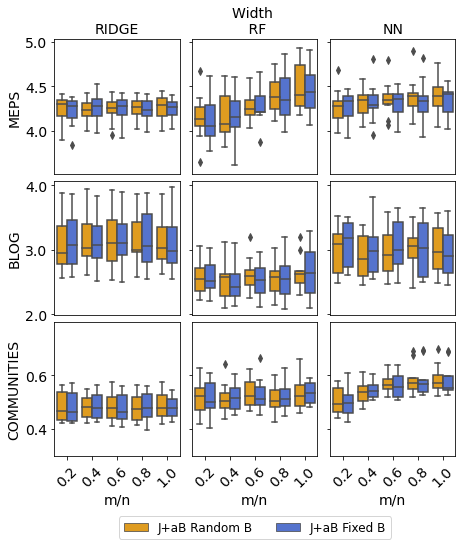

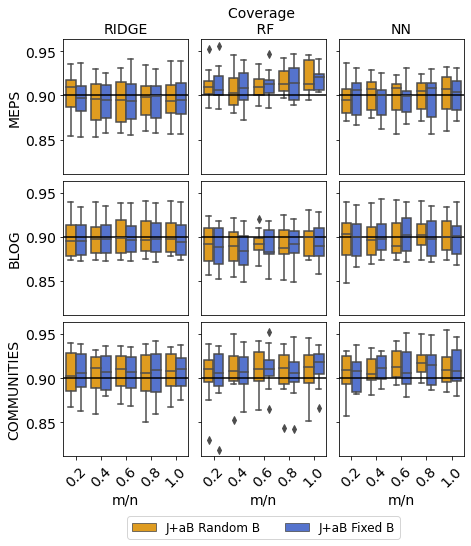

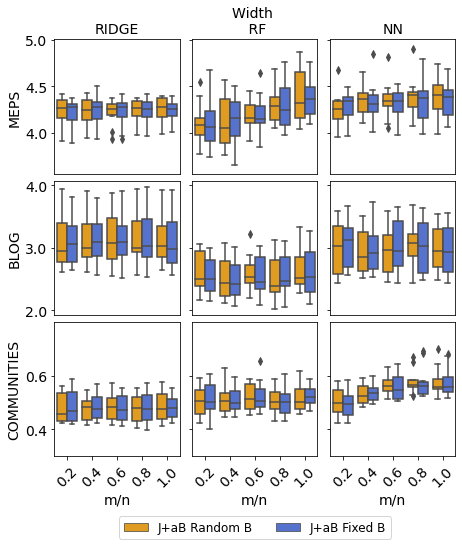

In [ ]:
for agg in ['mean', 'median', 'tmean']:
    grouped_box_rand_fix(agg, 'coverage')
    grouped_box_rand_fix(agg, 'width')

#### Computational Time

In [ ]:
nrow = 9
ncol = 3

row_names = ['Ridge  mean', 'Ridge median', 'Ridge  tmean', 'RF  mean',
             'RF  median', 'RF  tmean', 'NN  mean', 'NN  median', 'NN  tmean']
col_names = ['J+aB', 'J+ ENSEMBLE', 'J+ NON-ENSEMBLE']
meps_run_time = np.zeros((nrow, ncol))
blog_run_time = np.zeros((nrow, ncol))
communities_run_time = np.zeros((nrow, ncol))
for dname in ['meps', 'blog', 'communities']:
    np.set_printoptions(suppress=True)  # no scientific notation
    i = 0  # denote which rows are saturated
    for agg in ['mean', 'median', 'tmean']:
        results = pd.read_csv(f'{dname}-main-results-{agg}.csv')
        results.loc[results.method == 'jack+', 'method'] = 'jack+ (m=0)'  # for plotting
        m_vals = np.array([int(mtd.split('=')[1].split(')')[0])
                           for mtd in results.method])  # get m value
        method_name = np.array([mtd.split(' ')[0] for mtd in results.method])
        results['method'] = method_name
        # For proper legend
        results['method'].replace('jack+-naive', 'J+ ENSEMBLE', inplace=True)
        results['method'].replace('jack+aB', 'J+aB', inplace=True)
        results['method'].replace('jack+', 'J+ NON-ENSEMBLE', inplace=True)
        results['ratio'] = m_vals/max(m_vals)
        results = results[(results.method == 'J+ NON-ENSEMBLE') | (results.ratio == 0.6)]
        time = results.groupby(by=['muh_fun', 'method'])['time'].mean()
        time = time.reindex(['J+aB', 'J+ ENSEMBLE', 'J+ NON-ENSEMBLE'], level='method')
        time = time.reindex(['ridge2', 'random_forest_nB', 'neural_net'], level='muh_fun')
        time = list(time)
        for regr in ['ridge2', 'random_forest_nB', 'neural_net']:
            eval(f'{dname}_run_time')[i, :] = time[:3]  # By ridge
            eval(f'{dname}_run_time')[i+3, :] = time[3:6]  # By RF
            eval(f'{dname}_run_time')[i+6, :] = time[6:9]  # By NN
        i += 1
    # Average J+aB results, since it does not aggregate
    for j in range(3):
        eval(f'{dname}_run_time')[3*j, -1] = np.mean(eval(f'{dname}_run_time')[3*j:3*j+3, -1])
        eval(f'{dname}_run_time')[3*j+1:3*j+3, -1] = 0
    time_table = eval(f'{dname}_run_time')
    # Save to one decimal place
    exec(f'{dname}_run_time=np.round(time_table, 1)')
# Correspond to current Table S1 format
meps_run_time = pd.DataFrame(meps_run_time, index=row_names, columns=col_names)
blog_run_time = pd.DataFrame(blog_run_time, index=row_names, columns=col_names)
communities_run_time = pd.DataFrame(communities_run_time, index=row_names, columns=col_names)

In [ ]:
print(meps_run_time)

              J+aB  J+ ENSEMBLE  J+ NON-ENSEMBLE
Ridge  mean    0.2          2.1              0.4
Ridge median   0.5          2.8              0.0
Ridge  tmean   0.5          2.7              0.0
RF  mean       3.0         61.6              4.9
RF  median     3.9         63.1              0.0
RF  tmean      3.9         56.4              0.0
NN  mean       8.8        275.7             14.4
NN  median    10.2        213.9              0.0
NN  tmean     10.0        206.9              0.0


In [ ]:
print(blog_run_time)

              J+aB  J+ ENSEMBLE  J+ NON-ENSEMBLE
Ridge  mean    0.5          6.7              1.5
Ridge median   1.1          9.1              0.0
Ridge  tmean   1.2          9.0              0.0
RF  mean       8.7        191.3             11.1
RF  median     9.6        197.3              0.0
RF  tmean      9.7        197.1              0.0
NN  mean      36.8        835.8             46.4
NN  median    39.4        891.3              0.0
NN  tmean     37.7        843.7              0.0


In [ ]:
print(communities_run_time)

              J+aB  J+ ENSEMBLE  J+ NON-ENSEMBLE
Ridge  mean    0.1          0.8              0.1
Ridge median   0.1          0.9              0.0
Ridge  tmean   0.1          0.9              0.0
RF  mean       7.8        169.8              8.7
RF  median     7.8        169.9              0.0
RF  tmean      7.8        169.9              0.0
NN  mean       4.7        105.4             10.0
NN  median     4.7        106.0              0.0
NN  tmean      4.7        105.9              0.0
